In [51]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
import h5py
import scipy.stats

import sys
sys.path.insert(0, '..')
import borg_velocity.poisson_process as poisson_process

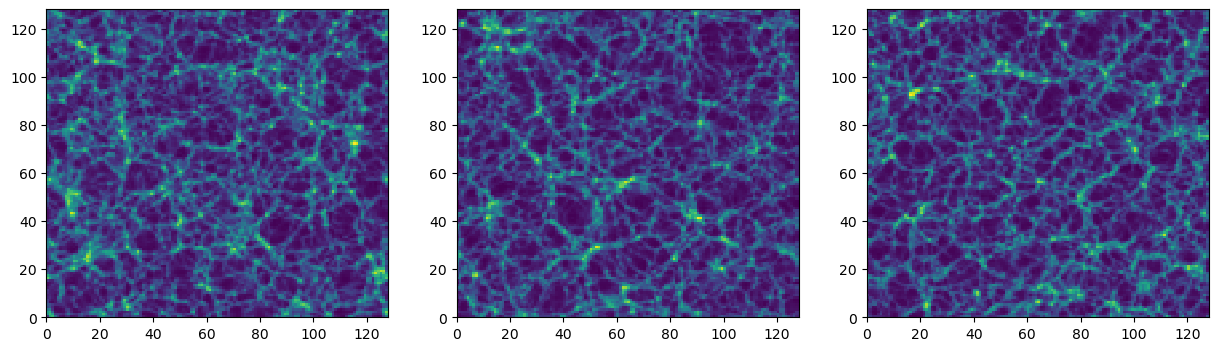

In [12]:
data_dir = '/data101/bartlett/fsigma8/borg_velocity/supranta_run_ic'

with h5py.File(pjoin(data_dir, 'mock_data.h5')) as f:
    delta = f['scalars/BORG_final_density'][:]

N = delta.shape[0]
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].pcolor(np.log10(2 + delta[N//2]))
axs[1].pcolor(np.log10(2 + delta[:,N//2,:]))
axs[2].pcolor(np.log10(2 + delta[...,N//2]))

# Try a radial selection parameterisation

$$
P(r) = r^2 \exp( - \lambda r / R_{\rm max})
$$

Need to choose an appropriate $\lambda$. The peak of this distribution is at $r = 2 R / \lambda$.

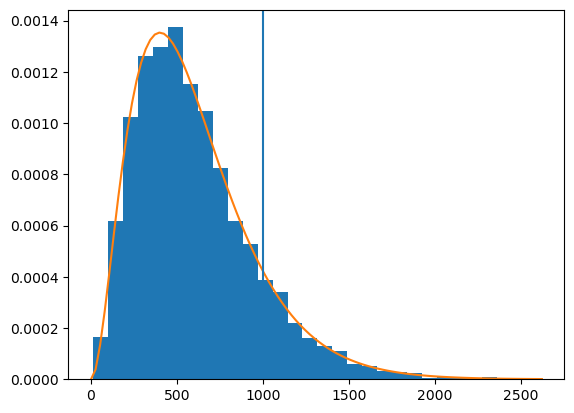

In [67]:
Rmax = 1000
lam = 5
nsamp = 10000

mydist = scipy.stats.gamma(a=3, scale=1/lam)
xsamp = mydist.rvs(nsamp) * Rmax

x = np.linspace(0, xsamp.max(), 100)
ypred0 = lam ** 3 / 2 * (x / Rmax) ** 2 * np.exp(- lam * x / Rmax) / Rmax

plt.hist(xsamp, bins=30, density=True)
plt.plot(x, ypred0)
plt.axvline(Rmax)

Draw samples

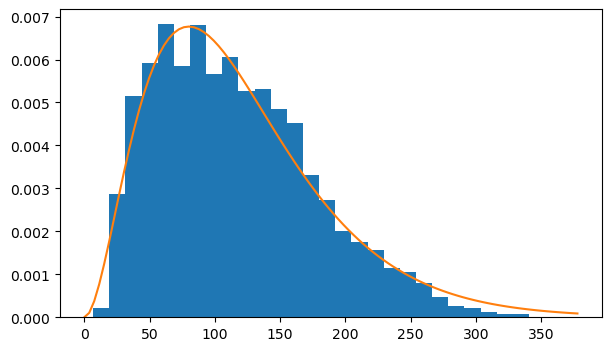

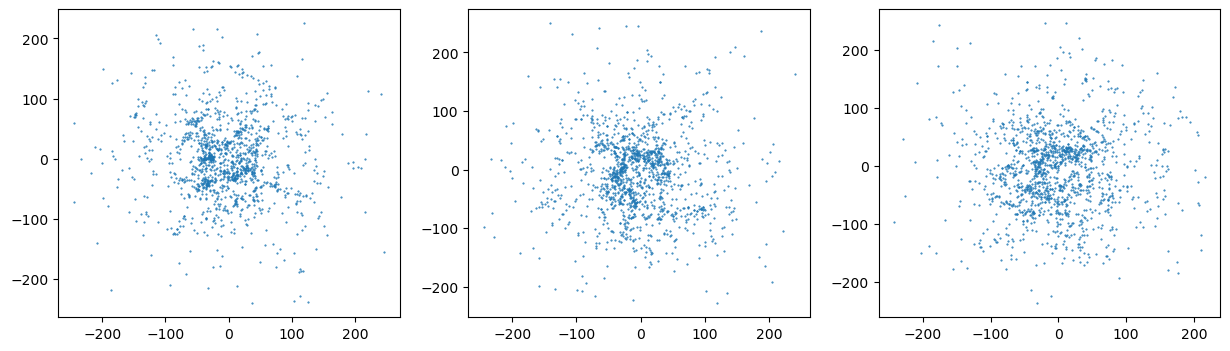

In [140]:
alpha = 1.4
Nt = 5000
bias_epsilon = 1e-7
L = 500
xmin = (-250, -250, -250)
lam = 5
Rmax = 200

phi = (1. + delta + bias_epsilon) ** alpha

# Create coordinates along each axis
x = np.linspace(xmin[0], xmin[0] + L, N)
y = np.linspace(xmin[1], xmin[1] + L, N)
z = np.linspace(xmin[2], xmin[2] + L, N)

# Create a 3D grid of coordinates
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Compute the radial distance from the origin (r = sqrt(x^2 + y^2 + z^2))
r = np.sqrt(X**2 + Y**2 + Z**2)

# Multiply phi by the corresponding radial selection
# Do not include r^2 factor as we are sampling in Cartesian 3D,
# so do not need the Jacobian term
# phi *= lam ** 3 / 2 * (r / Rmax) ** 2 * np.exp(- lam * r / Rmax) / Rmax
phi *= np.exp(- lam * r / Rmax)

coord_true = np.zeros((3,Nt))
coord_meas = np.zeros((3,Nt))

# Make Nt samples
ctrue = poisson_process.sample_3d(phi, Nt, L, xmin)
# cmeas, sig_mu[i] = radially_scatter(ctrue, frac_sig_x)
rtrue = np.sqrt(np.sum(ctrue**2,axis=0))

fig, ax = plt.subplots(1, 1, figsize=(7,4), sharex=True)
ax.hist(rtrue, density=True, bins=30)
x = np.linspace(0, rtrue.max(), 100)
ypred0 = lam ** 3 / 2 * (x / Rmax) ** 2 * np.exp(- lam * x / Rmax) / Rmax
ax.plot(x, ypred0)

fig, axs = plt.subplots(1, 3, figsize=(15,4))
dx = L / 20
m = ((ctrue[2] > -dx) & (ctrue[2] < dx))
axs[0].plot(ctrue[0,m], ctrue[1,m], '.', ms=1)
m = ((ctrue[1] > -dx) & (ctrue[1] < dx))
axs[1].plot(ctrue[0,m], ctrue[2,m], '.', ms=1)
m = ((ctrue[0] > -dx) & (ctrue[0] < dx))
axs[2].plot(ctrue[1,m], ctrue[2,m], '.', ms=1)

